# 分类训练

根据聚类信息，我们对氧化物、卤化物单独进行训练

In [1]:
# import libraries
import os
import sys
import numpy as np
import pandas as pd
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
MODEL_NAME = 'XGBoost'

In [2]:
current_path = os.getcwd()
current_path

'c:\\Users\\Fortyfour\\Desktop\\graduation_design\\New_Scripts'

In [3]:
# To import the custom module from a specific path
sys.path.insert(0, os.path.join(current_path, '../'))
# Importing the custom module
from Utools.SingleModel import SingleModel

In [4]:
from sklearn.base import clone
from xgboost import XGBRegressor

## Load Data

In [5]:
# Load data
file_dir = os.path.join(current_path, './Data')
# dft data
dft_train = pd.read_csv(os.path.join(file_dir, 'train_data', 'mp_plus_cluster_train_set.csv'))
dft_test = pd.read_csv(os.path.join(file_dir, 'test_data', 'mp_plus_cluster_test_set.csv'))

In [6]:
from pymatgen.core import Element
halogen = [Element(i) for i in ['F', 'Cl', 'Br', 'I']]
halogen

[Element F, Element Cl, Element Br, Element I]

In [7]:
#
from matminer.featurizers.conversions import StrToComposition

stc = StrToComposition(target_col_id='composition')
dft_train.rename(columns={'composition': 'composition_str'}, inplace=True)
dft_test.rename(columns={'composition': 'composition_str'}, inplace=True)
dft_train = stc.featurize_dataframe(dft_train, 'composition_str')
dft_test = stc.featurize_dataframe(dft_test, 'composition_str')

StrToComposition:   0%|          | 0/4371 [00:00<?, ?it/s]

StrToComposition:   0%|          | 0/1101 [00:00<?, ?it/s]

In [8]:
dft_train.head()

,composition_str,nsites,crystal_system,space_group,volume,density,density_atomic,efermi,energy_per_atom,formation_energy_per_atom,...,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,cluster,composition
0,Ag8B48Cl48,104,0,205,1920.521818,2.666186,18.466556,0.446000,-8.609923,-0.736951,...,0.0,0.0,64.0,225.0,161.0,123.461538,54.887574,64.0,3,"(Ag, B, Cl)"
1,Ag40Te16Br12,68,3,63,1688.336988,7.194734,24.828485,2.536429,-3.067222,-0.366432,...,0.0,0.0,64.0,225.0,161.0,179.411765,53.633218,225.0,0,"(Ag, Te, Br)"
2,Ag30P8S32Cl6,76,0,220,1709.591255,4.587131,22.494622,2.458781,-4.062215,-0.481548,...,0.0,0.0,2.0,225.0,223.0,123.552632,80.090028,70.0,1,"(Ag, P, S, Cl)"
3,Ag4Ge2S6,12,3,36,267.880017,4.767775,22.323335,2.600055,-4.253843,-0.466513,...,0.0,0.0,70.0,225.0,155.0,147.500000,77.500000,70.0,1,"(Ag, Ge, S)"
4,Ag8H16S12O48,84,3,33,1057.273255,3.191155,12.586586,0.517819,-5.785262,-1.449207,...,0.0,0.0,12.0,225.0,213.0,75.238095,73.768707,12.0,3,"(Ag, H, S, O)"


In [9]:
# 判断dft_train、dft_test中数据是否为卤化物
dft_train['is_halogen'] = dft_train['composition'].apply(
    lambda x: 1 if any(elem in halogen for elem in x.elements) else 0)
dft_test['is_halogen'] = dft_test['composition'].apply(
    lambda x: 1 if any(elem in halogen for elem in x.elements) else 0)

In [10]:
dft_train.head()

,composition_str,nsites,crystal_system,space_group,volume,density,density_atomic,efermi,energy_per_atom,formation_energy_per_atom,...,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,cluster,composition,is_halogen
0,Ag8B48Cl48,104,0,205,1920.521818,2.666186,18.466556,0.446000,-8.609923,-0.736951,...,0.0,64.0,225.0,161.0,123.461538,54.887574,64.0,3,"(Ag, B, Cl)",1
1,Ag40Te16Br12,68,3,63,1688.336988,7.194734,24.828485,2.536429,-3.067222,-0.366432,...,0.0,64.0,225.0,161.0,179.411765,53.633218,225.0,0,"(Ag, Te, Br)",1
2,Ag30P8S32Cl6,76,0,220,1709.591255,4.587131,22.494622,2.458781,-4.062215,-0.481548,...,0.0,2.0,225.0,223.0,123.552632,80.090028,70.0,1,"(Ag, P, S, Cl)",1
3,Ag4Ge2S6,12,3,36,267.880017,4.767775,22.323335,2.600055,-4.253843,-0.466513,...,0.0,70.0,225.0,155.0,147.500000,77.500000,70.0,1,"(Ag, Ge, S)",0
4,Ag8H16S12O48,84,3,33,1057.273255,3.191155,12.586586,0.517819,-5.785262,-1.449207,...,0.0,12.0,225.0,213.0,75.238095,73.768707,12.0,3,"(Ag, H, S, O)",0


In [11]:
# 是否存在既是氧化物又是卤化物
dft_train[dft_train['is_oxide'] == 1]['is_halogen'].value_counts()

is_halogen
0    1425
1     217
Name: count, dtype: int64

In [12]:
dft_train[dft_train['is_halogen'] == 1].shape, dft_train[dft_train['is_oxide'] == 1].shape, dft_train[(dft_train['is_oxide'] == 0) & (dft_train['is_halogen'] == 0)].shape

((1087, 148), (1642, 148), (1859, 148))

In [13]:
halogen_train = dft_train[dft_train['is_halogen'] == 1].copy()
oxide_train = dft_train[dft_train['is_oxide'] == 1].copy()
normal_train = dft_train[(dft_train['is_oxide'] == 0) & (dft_train['is_halogen'] == 0)].copy()
halogen_train.shape, oxide_train.shape, normal_train.shape

((1087, 148), (1642, 148), (1859, 148))

In [14]:
halogen_train_X = halogen_train.drop(columns=['composition', 'composition_str', 'cluster', 'is_oxide', 'is_halogen', 'band_gap'])
halogen_train_y = halogen_train['band_gap']
oxide_train_X = oxide_train.drop(columns=['composition', 'composition_str', 'cluster', 'is_oxide', 'is_halogen', 'band_gap'])
oxide_train_y = oxide_train['band_gap']
normal_train_X = normal_train.drop(columns=['composition', 'composition_str', 'cluster', 'is_oxide', 'is_halogen', 'band_gap'])
normal_train_y = normal_train['band_gap']

In [15]:
fig_path = os.path.join(current_path, 'figures', 'classification_train')
os.makedirs(fig_path, exist_ok=True)

In [16]:
def class_train(class_, dft_train_X, dft_train_y):
    """对同一cluster进行训练"""
    xgboost_best = XGBRegressor(learning_rate=0.1, max_depth=7, n_estimators=500,
        colsample_bytree=0.7, subsample=1.0, reg_lambda=1.0, alpha=0.5, 
        objective='reg:squarederror', random_state=RANDOM_SEED, n_jobs=-1)
    # record model metrics
    model_metrics = pd.DataFrame(columns=['Model', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
    # Train the model on dft data
    print("#" * 100)
    print(f"[DFT - {MODEL_NAME}] Training {MODEL_NAME} on DFT data:")
    print("-" * 100)

    dft_model = SingleModel(clone(xgboost_best), random_state=RANDOM_SEED)
    dft_model.train(dft_train_X, dft_train_y)

    # evaluate on the dft train set
    print(f"[Train_error] Evaluating DFT {MODEL_NAME} on DFT train set:")
    metrics = dft_model.evaluate(dft_train_X, dft_train_y, fig_path=os.path.join(fig_path, f'class_{class_}_train_error.png'), fig_show=False)
    model_metrics.loc[len(model_metrics)] = {
    'Model': MODEL_NAME,
    'Error_Type': 'Train',
    'Train_set': 'dft',
    'Test_set': 'dft',
    'R²': metrics['r2'],
    'RMSE': metrics['rmse'],
    'MAE': metrics['mae']
    }

    return dft_model

In [17]:
# train
train_X = {'halogen': halogen_train_X, 'oxide': oxide_train_X, 'normal': normal_train_X}
train_y = {'halogen': halogen_train_y, 'oxide': oxide_train_y, 'normal': normal_train_y}
models = {}
# Train models
for class_ in ['halogen', 'oxide', 'normal']:
    print(f"Training {class_} model...")
    dft_model = class_train(class_, train_X[class_], train_y[class_])
    # Save the model
    models[class_] = dft_model

Training halogen model...
####################################################################################################
[DFT - XGBoost] Training XGBoost on DFT data:
----------------------------------------------------------------------------------------------------
Starting model training...
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing model, total=   1.2s
Model training completed!
[Train_error] Evaluating DFT XGBoost on DFT train set:
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\classification_train\class_halogen_train_error.png

Model Evaluation Results:
Test set size: 1087
Test set: R²: 0.9972 RMSE: 0.0433 MAE: 0.0304 MAPE: 106.8643%
Training oxide model...
####################################################################################################
[DFT - XGBoost] Training XGBoost on DFT data:
---------------------------------------------------------------

In [18]:
# test_set
halogen_test = dft_test[dft_test['is_halogen'] == 1].copy()
oxide_test = dft_test[dft_test['is_oxide'] == 1].copy()
normal_test = dft_test[(dft_test['is_oxide'] == 0) & (dft_test['is_halogen'] == 0)].copy()

halogen_test_X = halogen_test.drop(columns=['composition', 'composition_str', 'cluster', 'is_oxide', 'is_halogen', 'band_gap'])
halogen_test_y = halogen_test['band_gap']
oxide_test_X = oxide_test.drop(columns=['composition', 'composition_str', 'cluster', 'is_oxide', 'is_halogen', 'band_gap'])
oxide_test_y = oxide_test['band_gap']
normal_test_X = normal_test.drop(columns=['composition', 'composition_str', 'cluster', 'is_oxide', 'is_halogen', 'band_gap'])
normal_test_y = normal_test['band_gap']

In [19]:
# group test
test_X = {'halogen': halogen_test_X, 'oxide': oxide_test_X, 'normal': normal_test_X}
test_y = {'halogen': halogen_test_y, 'oxide': oxide_test_y, 'normal': normal_test_y}
class_metrics = pd.DataFrame(columns=['Model', 'Class', 'Error_Type', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
for class_ in ['halogen', 'oxide', 'normal']:
    print(f"Testing {class_} model...")
    # Evaluate the model on the test set
    metrics = models[class_].evaluate(test_X[class_], test_y[class_], 
                                      fig_path=os.path.join(fig_path, f'class_{class_}_test_error.png'), fig_show=False)
    class_metrics.loc[len(class_metrics)] = {
        'Model': MODEL_NAME,
        'Class': class_,
        'Error_Type': 'Test',
        'Train_set': 'dft',
        'Test_set': 'dft',
        'R²': metrics['r2'],
        'RMSE': metrics['rmse'],
        'MAE': metrics['mae']
    }

class_metrics

Testing halogen model...
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\classification_train\class_halogen_test_error.png

Model Evaluation Results:
Test set size: 279
Test set: R²: 0.5025 RMSE: 0.5701 MAE: 0.4120 MAPE: 157.8107%
Testing oxide model...
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\classification_train\class_oxide_test_error.png

Model Evaluation Results:
Test set size: 389
Test set: R²: 0.4333 RMSE: 0.6499 MAE: 0.4762 MAPE: 1449.0115%
Testing normal model...
Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\classification_train\class_normal_test_error.png

Model Evaluation Results:
Test set size: 490
Test set: R²: 0.7659 RMSE: 0.3808 MAE: 0.2859 MAPE: 1911.8100%


,Model,Class,Error_Type,Train_set,Test_set,R²,RMSE,MAE
0,XGBoost,halogen,Test,dft,dft,0.502531,0.570139,0.412035
1,XGBoost,oxide,Test,dft,dft,0.433285,0.649850,0.476216
2,XGBoost,normal,Test,dft,dft,0.765886,0.380838,0.285901


In [20]:
# test
# 查看整体测试误差
# 对于测试集，我们将既是卤化物又是氧化物的样本放入氧化物模型进行测试
# 查看整个数据集的误差
y_pred = []
y_test = dft_test['band_gap'].values
# 对于dft_test中的每一个数据
for i in range(len(dft_test)):
    # 获取当前数据的class
    if dft_test.iloc[i]['is_oxide'] == 1:
        class_ = 'oxide'
    elif dft_test.iloc[i]['is_halogen'] == 1:
        class_ = 'halogen'
    else:
        class_ = 'normal'
    # 获取当前数据的特征
    test_X = dft_test.drop(columns=['composition_str', 'composition', 'band_gap', 'cluster', 'is_halogen', 'is_oxide']).iloc[i, :].to_frame().T
    # 预测
    y_pred.append(models[class_].predict(test_X))

y_pred = np.array(y_pred).reshape(-1)
y_pred

array([1.5721949, 2.003565 , 1.0847521, ..., 2.1018403, 1.9878536,
       1.9632679], shape=(1101,), dtype=float32)

Figure saved to: c:\Users\Fortyfour\Desktop\graduation_design\New_Scripts\figures\classification_train\whole_test_error.png


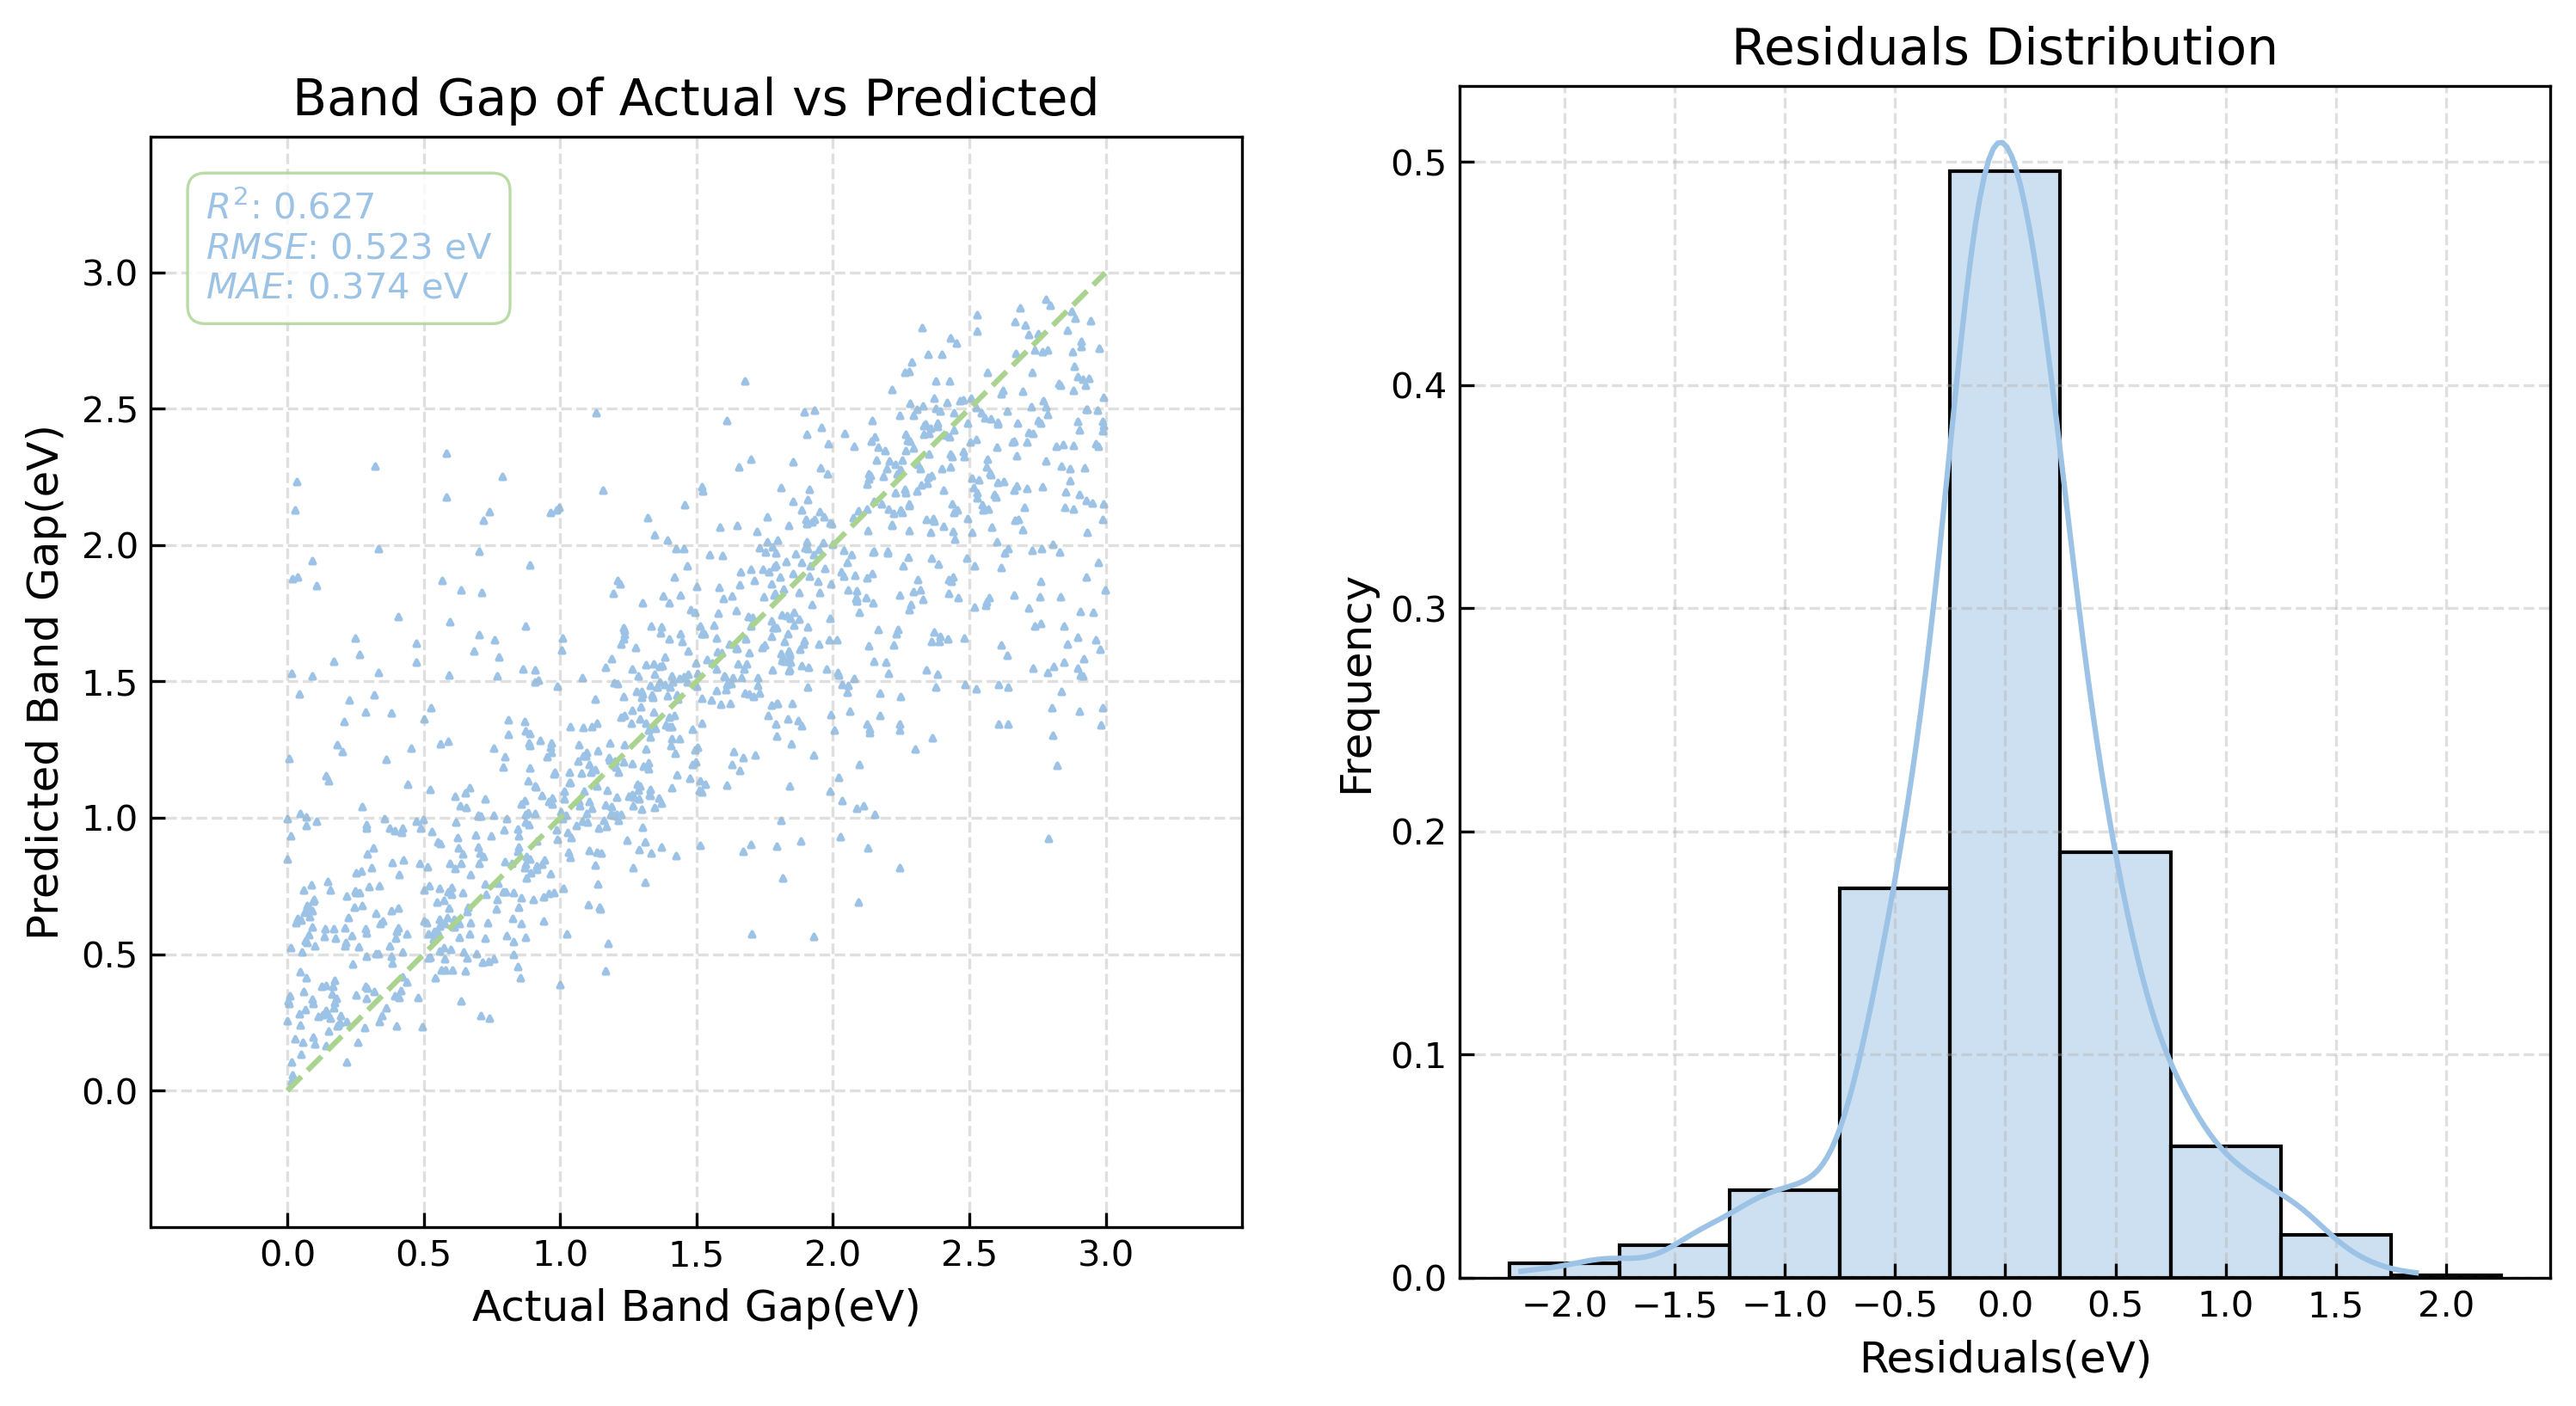

In [21]:
from Utools.draw import model_performance
test_r2, test_rmse, test_mae = model_performance(y_test, y_pred, fig_path=os.path.join(fig_path, 'whole_test_error.png')) 

In [22]:
whole_metrics = pd.DataFrame(columns=['Model', 'Train_set', 'Test_set', 'R²', 'RMSE', 'MAE'])
whole_metrics.loc[len(whole_metrics)] = {
    'Model': MODEL_NAME,
    'Train_set': 'dft',
    'Test_set': 'dft',
    'R²': test_r2,
    'RMSE': test_rmse,
    'MAE': test_mae
}
# Save the metrics to a CSV file
whole_metrics.to_csv(os.path.join('./metrics', 'classification_model_metrics.csv'), index=False)
whole_metrics

,Model,Train_set,Test_set,R²,RMSE,MAE
0,XGBoost,dft,dft,0.627163,0.522748,0.374301
